# Exploratory Data Analysis - prior authorization approval

### Project Goal  : build a model predicting  `pa_approved` based on the following features<br>
- `bin`  The BIN of the payer(insurance company) for the claim.
- `drug`   The drug that was associated with the claim.
- `reject_code`   If the claim was rejected, what was the associated rejection code. It tells you the reason why the claim has been rejected.
- `correct_diagnosis`    Flag for information provided by the provider indicating that the patient has the correct diagnosis for the associated drug.
- `tried_and_failed`    Flag for information provided by the provider indicating that the patient has tried and failed the relevant generic alternatives.
- `contraindication`    Flag for information provided by the provider indicating that the patient has an associated contraindication for the medication requested.

### summary
In this notebook, <br>
1. we plot the relative frequency distributions of the variables `bin`, `drug`, `correct_diagnosis`, `tried_and_failed`, `contraindication` and `pharmacy_claim_approved`.<br><br>
2. To find a correlation between features,
- Calculate Cramer's V correlations between features.
- plot the relative frequency value distribution of the feature 'reject_code' for every possible combinations of 'bin' and 'drug' values. <br><br>
3. To see if there is any interaction between features,
- For each feature, we plot the approval rates for each value of the feature.
- For each pair of features, we plot the heatmap of the approval rates for each pair of values.

As a result, we
- Drop the redundant feature `reject_code`.
- Add the interaction terms of (`bin`, `drug`), (`tried_and_faild`,`drug`) and (`contraindication`,`drug`).

## 0. Data preprocessing

Load and merge data into a single dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [2]:
# load data
cl =pd.read_csv('data/dim_claims.csv')
pa = pd.read_csv('data/dim_pa.csv')
bridge = pd.read_csv('data/bridge.csv')

In [3]:
# merge data
claim = bridge.merge(cl.copy(), how = 'inner', on = 'dim_claim_id')
claim = claim.dropna()
claim = claim.merge(pa.copy(), how = 'inner', on = 'dim_pa_id')
claim = claim.drop(['dim_claim_id','dim_date_id','pharmacy_claim_approved'], axis = 1)

In [4]:
claim.head()

,dim_pa_id,bin,drug,reject_code,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1.0,417380,A,75.0,1,1,0,1
1,2.0,417740,A,76.0,1,0,0,1
2,3.0,417380,A,75.0,0,0,1,1
3,4.0,999001,A,76.0,1,1,0,1
4,5.0,417614,A,70.0,0,1,0,1


In [5]:
claim.columns

Index(['dim_pa_id', 'bin', 'drug', 'reject_code', 'correct_diagnosis',
       'tried_and_failed', 'contraindication', 'pa_approved'],
      dtype='object')

In [6]:
# y:target variable, X:features 
y=claim.iloc[:,7]
X=claim.drop(['dim_pa_id','pa_approved'], axis = 1)

Split data into three parts 'pre(process)', 'train' and 'test'.<br>
- `X_pre`, `y_pre` will be used for the exploratory data analysis, feature selection and hyperparameter tuning.
- `X_train`, `y_train` will be used for model selection.
- `X_test`, `y_test` will be used for model assessment.

In [7]:
# data split => preprocess : train : test = 3:1:1

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(),
                                                    shuffle = True,
                                                    random_state = 623,
                                                    test_size = .2,
                                                    stratify = y.copy())

X_pre, X_train, y_pre, y_train = train_test_split(X_train.copy(), y_train.copy(),
                                                  shuffle = True,
                                                  random_state = 623,
                                                  test_size = .25,
                                                  stratify = y_train.copy())

From now on, we are going to use preprocessing set for exploratory data analysis.

## 1. Relative Frequency Value Distributions

In [8]:
X_pre.columns

Index(['bin', 'drug', 'reject_code', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

Here we plot bar charts for the relative frequency distributions.

Possible values of 'bin' are [417740 417380 417614 999001]


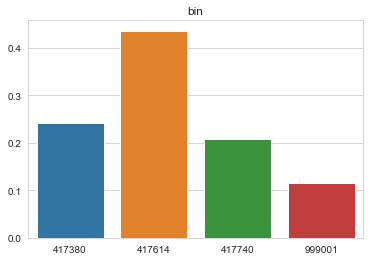



Possible values of 'drug' are ['B' 'A' 'C']


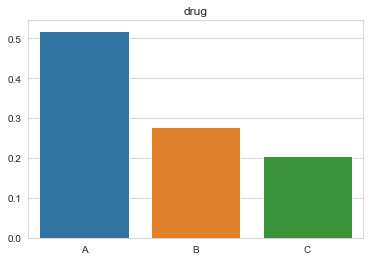



Possible values of reject_code are [70. 75. 76.]

- 70 : drug is not covered by the plan and is not on formulary, and typically implies that another course of therapy should be pursued
- 75 : drug is on the formulary but does not have preferred status and requires a prior authorization (PA)
- 76 : the drug is covered, but that the plan limitations have been exceeded, which means that the limitations on the number of fills for that medication has been met


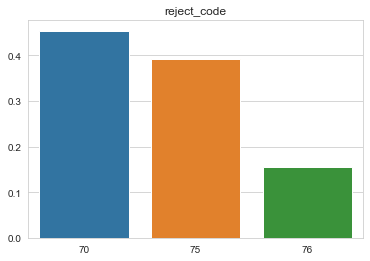



Possible values of correct_diagnosis are [0 1]

1 : the diagnosis is correct
0 : the diagnosis is incorrect


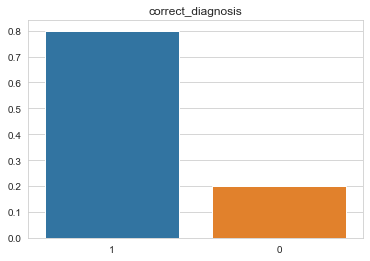



Possible values of tried_and_failed are [0 1]

1: generic alternatives have been failed
0 : generic alternative did not fail


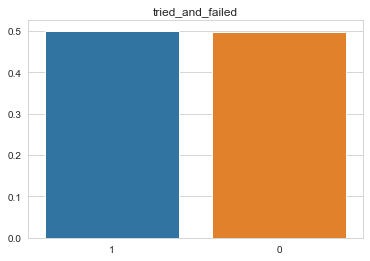



Possible values of contraindication are [0 1]

1: the patient has an associated contraindication
0 : the patient does not have an associated contraindication


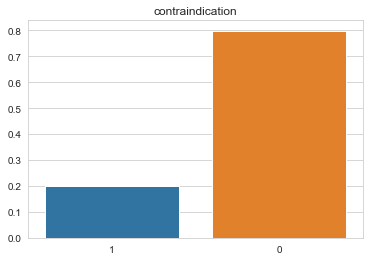



Possible values of our target variable pa_approved are [1 0]
1: prior authorization has been approved
0: prior authorization has been disapproved


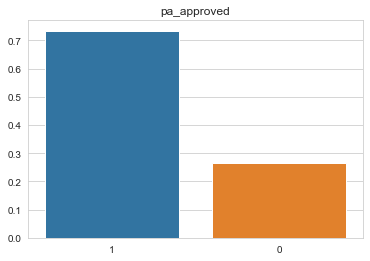

In [9]:
# the relative frequency distribution of the feature 'bin'
print("Possible values of \'bin\' are", X_pre.bin.unique())

bin_val = pd.DataFrame({417380 : round(X_pre.bin.value_counts()[417380]/X_pre.shape[0],3),
                        417614 : round(X_pre.bin.value_counts()[417614]/X_pre.shape[0],3),
                        417740 : round(X_pre.bin.value_counts()[417740]/X_pre.shape[0],3),
                        999001 : round(X_pre.bin.value_counts()[999001]/X_pre.shape[0],3)}, 
                       index = ['ratio'])
sns.barplot(data=bin_val).set(title='bin')
plt.show()



print()
print()


# the relative frequency distribution of the feature 'drug'
print("Possible values of \'drug\' are", X_pre.drug.unique())

drug_val = pd.DataFrame({'A' : round(X_pre.drug.value_counts()['A']/X_pre.shape[0],3),
                         'B' : round(X_pre.drug.value_counts()['B']/X_pre.shape[0],3),
                         'C' : round(X_pre.drug.value_counts()['C']/X_pre.shape[0],3)}, 
                        index = ['ratio'])
sns.barplot(data=drug_val).set(title='drug')
plt.show()


print()
print()


# the relative frequency distribution of the feature 'reject_code'
print("Possible values of reject_code are", X_pre.reject_code.unique())
print()
print('- 70 : drug is not covered by the plan and is not on formulary, and typically implies that another course of therapy should be pursued') 
print('- 75 : drug is on the formulary but does not have preferred status and requires a prior authorization (PA)') 
print('- 76 : the drug is covered, but that the plan limitations have been exceeded, which means that the limitations on the number of fills for that medication has been met')
reject_code_val = pd.DataFrame({70 : round(X_pre.reject_code.value_counts()[70]/X_pre.shape[0],3),
                                75 : round(X_pre.reject_code.value_counts()[75]/X_pre.shape[0],3),
                                76 : round(X_pre.reject_code.value_counts()[76]/X_pre.shape[0],3)}, 
                        index = ['ratio'])
sns.barplot(data=reject_code_val).set(title='reject_code')
plt.show()


print()
print()


# the relative frequency distribution of the feature 'correct_diagnosis'
print("Possible values of correct_diagnosis are", X_pre.correct_diagnosis.unique())
print()
print('1 : the diagnosis is correct')
print('0 : the diagnosis is incorrect')
correct_diagnosis_val = pd.DataFrame({1 : round(X_pre.correct_diagnosis.value_counts()[1]/X_pre.shape[0],3),
                                      0 : round(X_pre.correct_diagnosis.value_counts()[0]/X_pre.shape[0],3)}, 
                        index = ['ratio'])
sns.barplot(data=correct_diagnosis_val).set(title='correct_diagnosis')
plt.show()



print()
print()


# the relative frequency distribution of the feature 'tried_and_failed'
print("Possible values of tried_and_failed are", X_pre.tried_and_failed.unique())
print()
print('1: generic alternatives have been failed')
print('0 : generic alternative did not fail')
tried_and_failed_val = pd.DataFrame({1 : round(X_pre.tried_and_failed.value_counts()[1]/X_pre.shape[0],3),
                                     0 : round(X_pre.tried_and_failed.value_counts()[0]/X_pre.shape[0],3)}, 
                                    index = ['ratio'])
sns.barplot(data=tried_and_failed_val).set(title='tried_and_failed')
plt.show()


print()
print()


# the relative frequency distribution of the feature 'contraindication'
print("Possible values of contraindication are", X_pre.contraindication.unique())
print()
print('1: the patient has an associated contraindication')
print('0 : the patient does not have an associated contraindication')
contraindication_val = pd.DataFrame({1 : round(X_pre.contraindication.value_counts()[1]/X_pre.shape[0],3),
                                     0 : round(X_pre.contraindication.value_counts()[0]/X_pre.shape[0],3)}, 
                                    index = ['ratio'])
sns.barplot(data=contraindication_val).set(title='contraindication')
plt.show()


print()
print()


# the relative frequency distribution of the target variable 'pa_approved'
print("Possible values of our target variable pa_approved are", y_pre.unique())
print('1: prior authorization has been approved')
print('0: prior authorization has been disapproved')
pa_approved_val = pd.DataFrame({1 : round(y_pre.value_counts()[1]/X_pre.shape[0],3),
                                0 : round(y_pre.value_counts()[0]/X_pre.shape[0],3)}, 
                               index = ['ratio'])
sns.barplot(data=pa_approved_val).set(title='pa_approved')
plt.show()

## 2. Redundant Variables

- First, we calculate the `Cramer's V correlations` between features to see if there is any correlation between them.
- Next, we plot the result in a heatmap.
- Note that `Cramer's V correlation` measures the correlation between nominal categorical variables.

In [10]:
X_pre.columns

Index(['bin', 'drug', 'reject_code', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

In [11]:
X_pre.columns[0:6]

Index(['bin', 'drug', 'reject_code', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

Text(0.5, 1.0, "cramer's V correlation")

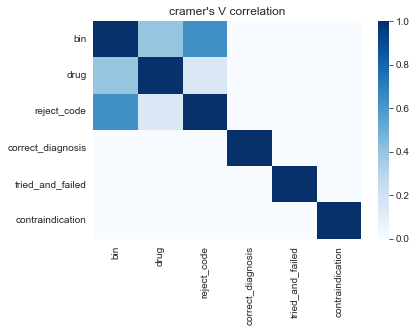

In [12]:
# Cramer's V correlations
cramer =  np.zeros((len(X_pre.columns[0:6]),len(X_pre.columns[0:6])))
# pairwise Cramer's V correlations
i=0
for x in X_pre.columns[0:6] :
    j=0
    for w in X_pre.columns[0:6] :
        data = pd.crosstab(index=X_pre[x], columns=X_pre[w])
        X2 = stats.chi2_contingency(data,correction=False)[0]
        n = np.sum(np.sum(data))
        minimum_dimension = min(data.shape)-1
        result = round(np.sqrt((X2/n) / minimum_dimension),3)
        cramer[i,j] = result
        j+=1
    i+=1
# heat map for Cramer's V correlations
cramer = pd.DataFrame(data = cramer, 
                      columns = X_pre.columns[0:6],
                     index = X_pre.columns[0:6])
sns.heatmap(cramer, cmap="Blues")
plt.title('cramer\'s V correlation')

- The heatmap above implies that there is some correlation between features `bin`,`drug` and `reject_code`. 
- Recall that in the note 0. EDA-pharmacy_claim_approval(hyperlink), we conjectured that each insurance company has a fixed policy for handling pharmacy claims for certain drugs because `bin` and `drug` almost determined the variable `pharmacy_claim_approved`.
- It is natural to extend this hypothesis from `pharmacy_claim_approval` to `reject_code` i.e. `bin` and `drug` almost determines `reject_code`.
- Below, we will plot bar charts for the relative frequency distributions of the feature 'reject_code' for fixed 'bin' and 'drug' values.

In [13]:
X_pre.columns

Index(['bin', 'drug', 'reject_code', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

417740 B
0    20001
1    12838
Name: pa_approved, dtype: int64


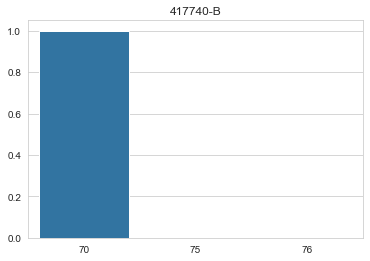

417740 A
1    5849
0     641
Name: pa_approved, dtype: int64


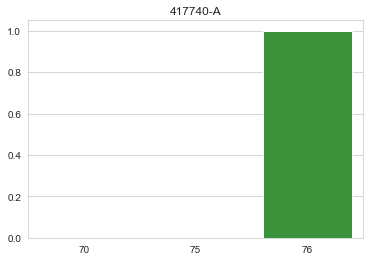

417740 C
1    24993
0     5023
Name: pa_approved, dtype: int64


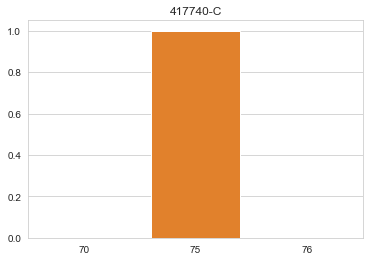

417380 B
1    2406
0     238
Name: pa_approved, dtype: int64


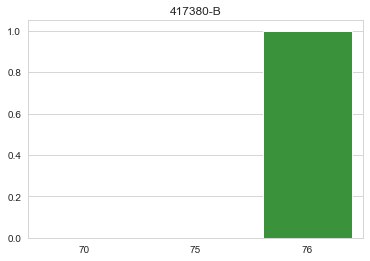

417380 A
1    52694
0      534
Name: pa_approved, dtype: int64


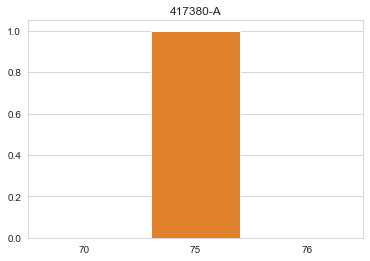

417380 C
0    16424
1     8195
Name: pa_approved, dtype: int64


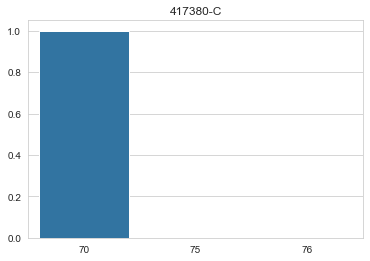

417614 B
1    45923
0     1282
Name: pa_approved, dtype: int64


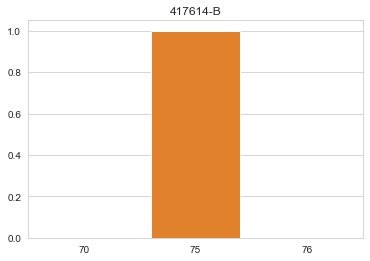

417614 A
1    54666
0    39306
Name: pa_approved, dtype: int64


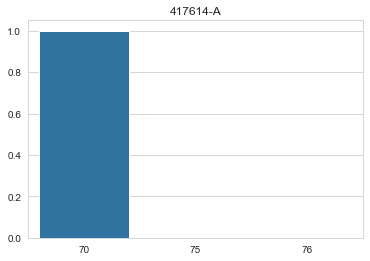

417614 C
1    2717
0    1551
Name: pa_approved, dtype: int64


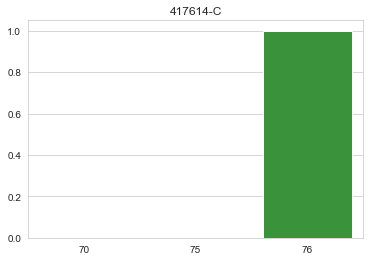

999001 B
1    9132
0     668
Name: pa_approved, dtype: int64


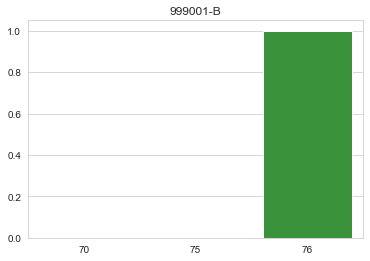

999001 A
1    18641
0      715
Name: pa_approved, dtype: int64


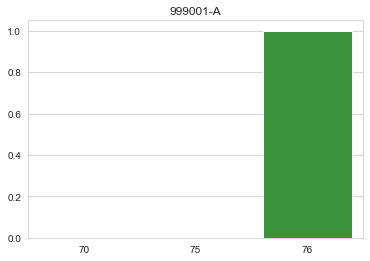

999001 C
1    6937
0    2196
Name: pa_approved, dtype: int64


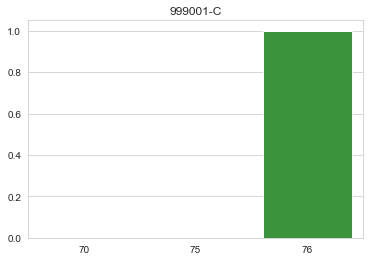

In [14]:
# the relative frequency distributions of the feature 'reject_code' for fixed 'bin' and 'drug' values
for i in X_pre.bin.unique() :
    for j in X_pre.drug.unique() :
        print(i,j)
        print(y_pre.loc[(X_pre.bin == i) & (X_pre.drug == j)].value_counts())    
        pa_approved_val = pd.DataFrame({70 : round(y_pre.loc[(X_pre.bin == i) & (X_pre.drug == j) & (X_pre.reject_code ==70)].shape[0]/y_pre[(X_pre.bin == i) & (X_pre.drug == j)].shape[0],3),
                                        75 : round(y_pre.loc[(X_pre.bin == i) & (X_pre.drug == j) & (X_pre.reject_code ==75)].shape[0]/y_pre[(X_pre.bin == i) & (X_pre.drug == j)].shape[0],3),
                                        76 : round(y_pre.loc[(X_pre.bin == i) & (X_pre.drug == j) & (X_pre.reject_code ==76)].shape[0]/y_pre[(X_pre.bin == i) & (X_pre.drug == j)].shape[0],3)}, 
                                       index = ['ratio'])
        sns.barplot(data=pa_approved_val).set(title=str(i)+"-"+str(j))
        plt.show()

- According to the bar charts above, once we fix `bin` and `drug` values, the relative frequency distribution is concentrated at a single value.
- This implies that 'reject_code' is (almost) determined by `bin` and `drug` i.e. `reject_code` is a redundant variable.
- We drop `reject_code` from our models.

In [15]:
# drop the column 'reject_code'
X_pre = X_pre.drop('reject_code', axis = 1)
X_train = X_train.drop('reject_code', axis = 1)
X_test = X_test.drop('reject_code', axis = 1)

In [16]:
X_pre.columns

Index(['bin', 'drug', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

## 3. Interacting Variables

In [17]:
X_pre.columns

Index(['bin', 'drug', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

For each feature, we plot the prior authorization approval rates of the patients with specific feature values.

'bin'


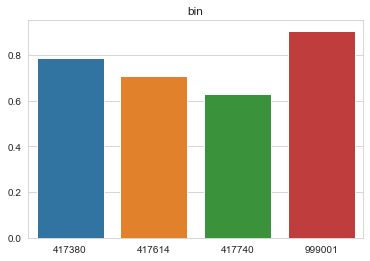



'drug'


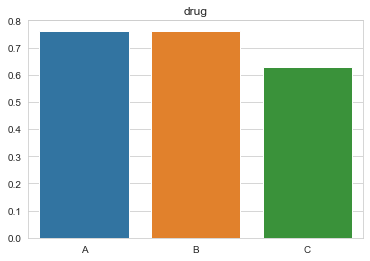



'correct_diagnosis'


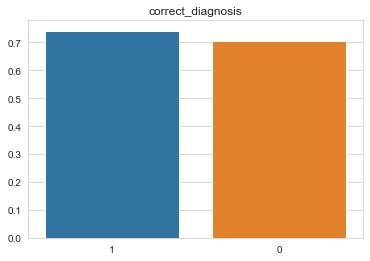



'tried_and_failed'


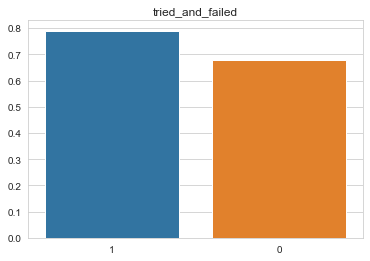



'contraindication'


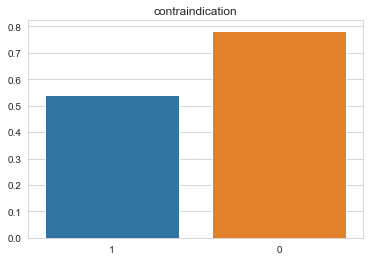

In [18]:
# plot the approval rates for the patients with specific 'bin' values.
print("\'bin\'")

bin_val = pd.DataFrame({417380 : X_pre[(X_pre.bin == 417380) & (y_pre == 1)].shape[0]/X_pre[X_pre.bin == 417380].shape[0],
                        417614 : X_pre[(X_pre.bin == 417614) & (y_pre == 1)].shape[0]/X_pre[X_pre.bin == 417614].shape[0],
                        417740 : X_pre[(X_pre.bin == 417740) & (y_pre == 1)].shape[0]/X_pre[X_pre.bin == 417740].shape[0],
                        999001 : X_pre[(X_pre.bin == 999001) & (y_pre == 1)].shape[0]/X_pre[X_pre.bin == 999001].shape[0]}, 
                       index = ['approval_rate'])
sns.barplot(data=bin_val).set(title='bin')
plt.show()



print()
print()


# plot the approval rates for the patients with specific 'drug' values.
print("\'drug\'")

drug_val = pd.DataFrame({'A' : X_pre[(X_pre.drug == 'A') & (y_pre == 1)].shape[0]/X_pre[X_pre.drug == 'A'].shape[0],
                         'B' : X_pre[(X_pre.drug == 'B') & (y_pre == 1)].shape[0]/X_pre[X_pre.drug == 'B'].shape[0],
                         'C' : X_pre[(X_pre.drug == 'C') & (y_pre == 1)].shape[0]/X_pre[X_pre.drug == 'C'].shape[0]}, 
                       index = ['approval_rate'])
sns.barplot(data=drug_val).set(title='drug')
plt.show()



print()
print()

# plot the approval rates for the patients with specific 'correct_diagnosis' values.
print("\'correct_diagnosis\'")

correct_diagnosis_val = pd.DataFrame({1 : X_pre[(X_pre.correct_diagnosis == 1) & (y_pre == 1)].shape[0]/X_pre[X_pre.correct_diagnosis == 1].shape[0],
                                      0 : X_pre[(X_pre.correct_diagnosis == 0) & (y_pre == 1)].shape[0]/X_pre[X_pre.correct_diagnosis == 0].shape[0]}, 
                                     index = ['approval_rate'])
sns.barplot(data=correct_diagnosis_val).set(title='correct_diagnosis')
plt.show()



print()
print()


# plot the approval rates for the patients with specific 'tried_and_failed' values.
print("\'tried_and_failed\'")

tried_and_failed_val = pd.DataFrame({1 : X_pre[(X_pre.tried_and_failed == 1) & (y_pre == 1)].shape[0]/X_pre[X_pre.tried_and_failed == 1].shape[0],
                                     0 : X_pre[(X_pre.tried_and_failed == 0) & (y_pre == 1)].shape[0]/X_pre[X_pre.tried_and_failed == 0].shape[0]}, 
                                    index = ['approval_rate'])
sns.barplot(data=tried_and_failed_val).set(title='tried_and_failed')
plt.show()



print()
print()


# plot the approval rates for the patients with specific 'contraindication' values.
print("\'contraindication\'")

contraindication_val = pd.DataFrame({1 : X_pre[(X_pre.contraindication == 1) & (y_pre == 1)].shape[0]/X_pre[X_pre.contraindication == 1].shape[0],
                                     0 : X_pre[(X_pre.contraindication == 0) & (y_pre == 1)].shape[0]/X_pre[X_pre.contraindication == 0].shape[0]}, 
                                    index = ['approval_rate'])
sns.barplot(data=contraindication_val).set(title='contraindication')
plt.show()

Summary of the overall trends
- the approval rate of the patients with `bin`== 999001>`bin` == 417380>`bin` == 417614>`bin` == 417740.
- the approval rate of the patients with `drug`=='A'≈ `drug`=='B'>`drug`=='C'.
- the approval rate of the patients with `correct_diagnosis`== 1>`correct_diagnosis`== 0.
- the approval rate of the patients with `tried_and_failed`== 1>`tried_and_failed`== 0.
- the approval rate of the patients with `contraindication`== 0>`contraindication`== 1.

In [19]:
X_pre.columns

Index(['bin', 'drug', 'correct_diagnosis', 'tried_and_failed',
       'contraindication'],
      dtype='object')

We will see how the interaction between features affect the prior authorization approval rate.

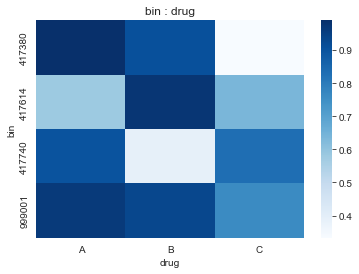

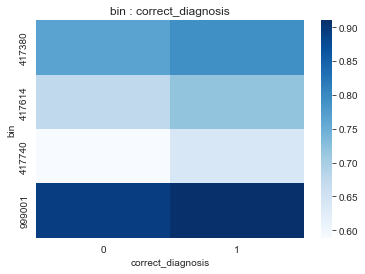

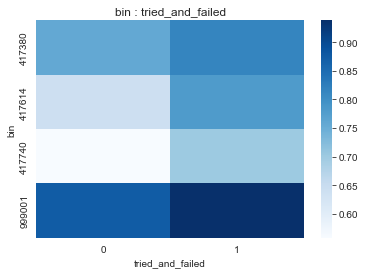

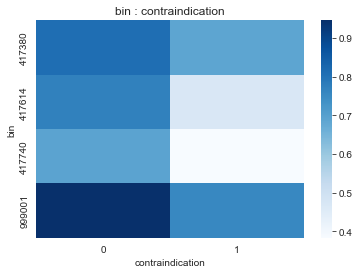

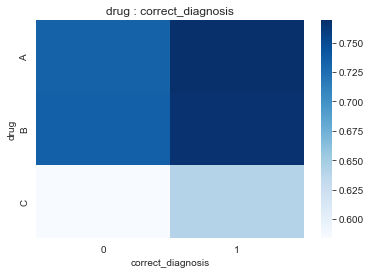

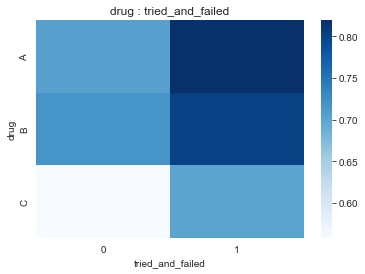

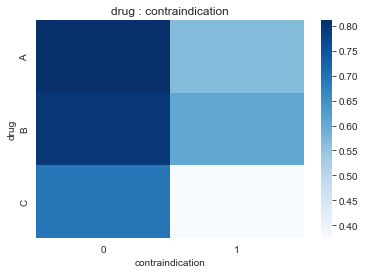

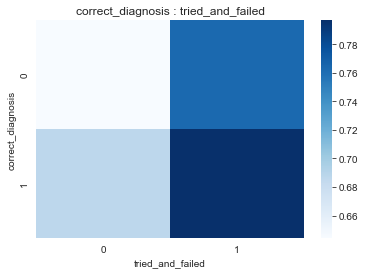

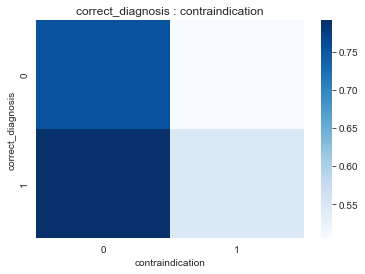

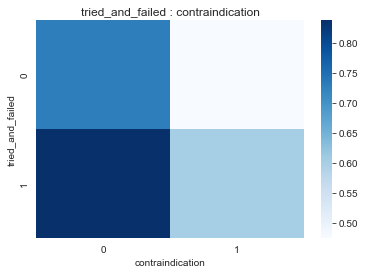

In [20]:
# For each pair of features, we plot the heatmaps of the approval rates for each pair of values
i=0
for x in X_pre.columns :
    j=0
    for w in X_pre.columns[i+1:] :
        data = pd.crosstab(index=X_pre.loc[y_pre == 1, x], columns=X_pre.loc[y_pre == 1, w])/pd.crosstab(index=X_pre.loc[:, x], columns=X_pre.loc[:, w])
        sns.heatmap(data, cmap="Blues")
        plt.title(str(x)+' : '+str(w))
        plt.show()
        j+=1
    i+=1

- the color in each square represents the number of patients with the vertical horizontal label values.
- For example, for the first heatmap the color of the square at the top left corner represents the number of patients with 'bin'== 417380, 'drug' == 'A'.
- Most of the heatmaps are <i>"regular"</i> except the heatmap between pairs (`bin`, `drug`), (`tried_and_faild`,`drug`),(`contraindication`,`drug`).
- The heatmaps are <i>"irregular"</i> in a sense that the heatmaps do not follow the overall trends that we observed above. For example,
- If we restrict our attention to patients with `drug`=='A', the approval rate of the patients with `bin`== 417614>`bin`== 417380>`bin`== 999001>`bin`== 417740 which is quite different from the overall trend  the approval rate of the patients with `bin`== 999001>`bin` == 417380>`bin` == 417614>`bin` == 417740.
- If we restrict our attention to the patients with `tried_and_failed` == 0, the approval rate of the patients with `drug`=='B'>`drug`=='A'>`drug`=='C'which is quite different from the overall trend the approval rate of the patients with `drug`=='A'≈ `drug`=='B'>`drug`=='C'.
- If we restrict our attention to the patients with `contraindication` == 1, the approval rate of the patients with `drug`=='B'>`drug`=='A'>`drug`=='C'which is quite different from the overall trend the approval rate of the patients with `drug`=='A'≈ `drug`=='B'>`drug`=='C'.
- This "irregular" behavior of the heatmaps resulted from interactions between features.
- Therefore, we add interaction terms of the pairs (`bin`, `drug`), (`tried_and_faild`,`drug`),(`contraindication`,`drug`).
- We will use these interaction terms to model logistic regression model later.

One hot encoding of nominal categorical variables `bin` and `drug`.

In [21]:
# one hot encoding of categorical variable 'bin'
for i in pd.get_dummies(X_pre.bin).columns :
    X_pre.loc[:,i] = pd.get_dummies(X_pre.bin).loc[:, i].copy()
for i in pd.get_dummies(X_train.bin).columns :
    X_train.loc[:,i] = pd.get_dummies(X_train.bin).loc[:, i].copy()
for i in pd.get_dummies(X_test.bin).columns :
    X_test.loc[:,i] = pd.get_dummies(X_test.bin).loc[:, i].copy()

# one hot encoding of categorical variable 'drug'
for i in pd.get_dummies(X_pre.drug).columns :
    X_pre.loc[:,i] = pd.get_dummies(X_pre.drug).loc[:, i].copy()
for i in pd.get_dummies(X_train.drug).columns :
    X_train.loc[:,i] = pd.get_dummies(X_train.drug).loc[:, i].copy()
for i in pd.get_dummies(X_test.drug).columns :
    X_test.loc[:,i] = pd.get_dummies(X_test.drug).loc[:, i].copy()

In [22]:
# the dataframes that only involves one hot encoded features
X_pre = X_pre.drop('bin', axis=1)
X_pre = X_pre.drop('drug', axis=1)
X_train = X_train.drop('bin', axis=1)
X_train = X_train.drop('drug', axis=1)
X_test = X_test.drop('bin', axis=1)
X_test = X_test.drop('drug', axis=1)

In [23]:
X_pre.columns

Index(['correct_diagnosis',  'tried_and_failed',  'contraindication',
                    417380,              417614,              417740,
                    999001,                 'A',                 'B',
                       'C'],
      dtype='object')

In [24]:
X_inter_pre = X_pre.copy()
X_inter_train = X_train.copy()
X_inter_test = X_test.copy()

Add interaction terms of the pairs (`bin`, `drug`), (`tried_and_faild`,`drug`),(`contraindication`,`drug`).

In [25]:
# encoding interaction terms of variable pairs

# 'bin' and 'drug'
for i in X_pre.columns[3:7] :
    for j in X_pre.columns[7:10] : 
        X_inter_pre.loc[:,str(i)+j] = X_pre.loc[:,i] * X_pre.loc[:,j]
for i in X_train.columns[3:7] :
    for j in X_train.columns[7:10] : 
        X_inter_train.loc[:,str(i)+j] = X_train.loc[:,i] * X_train.loc[:,j]
for i in X_train.columns[3:7] :
    for j in X_test.columns[7:10] : 
        X_inter_test.loc[:,str(i)+j] = X_test.loc[:,i] * X_test.loc[:,j]
        
# 'tried_and_failed' and 'drug'
for j in X_pre.columns[7:10] : 
    X_inter_pre.loc[:,'tried_and_failed'+j] = X_pre.loc[:,'tried_and_failed'] * X_pre.loc[:,j]
for j in X_train.columns[7:10] : 
    X_inter_train.loc[:,'tried_and_failed'+j] = X_train.loc[:,'tried_and_failed'] * X_train.loc[:,j]
for j in X_test.columns[7:10] : 
    X_inter_test.loc[:,'tried_and_failed'+j] = X_test.loc[:,'tried_and_failed'] * X_test.loc[:,j]
        
# 'contraindication' and 'drug'
for j in X_pre.columns[7:10] : 
    X_inter_pre.loc[:,'contraindication'+j] = X_pre.loc[:,'contraindication'] * X_pre.loc[:,j]
for j in X_train.columns[7:10] : 
    X_inter_train.loc[:,'contraindication'+j] = X_train.loc[:,'contraindication'] * X_train.loc[:,j]
for j in X_test.columns[7:10] : 
    X_inter_test.loc[:,'contraindication'+j] = X_test.loc[:,'contraindication'] * X_test.loc[:,j]

In [26]:
X_inter_pre.head()

,correct_diagnosis,tried_and_failed,contraindication,417380,417614,417740,999001,A,B,C,...,417740C,999001A,999001B,999001C,tried_and_failedA,tried_and_failedB,tried_and_failedC,contraindicationA,contraindicationB,contraindicationC
153421,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
485561,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
505492,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
418732,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
416077,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


# 4. Save Data

In [27]:
# save dataframes as csv files

X_pre.to_csv('data/X_pre',header = True, index = True)
X_train.to_csv('data/X_train',header = True, index = True)
X_test.to_csv('data/X_test',header = True, index = True)

X_inter_pre.to_csv('data/X_inter_pre',header = True, index = True)
X_inter_train.to_csv('data/X_inter_train',header = True, index = True)
X_inter_test.to_csv('data/X_inter_test',header = True, index = True)

y_pre.to_csv('data/y_pre',header = True, index = True)
y_train.to_csv('data/y_train',header = True, index = True)
y_test.to_csv('data/y_test',header = True, index = True)